# dowhy tutorial
- dowhy에서 제공하는 4-step을 이용하여 causal inference

## 00. data setup

In [6]:
import numpy as np
import pandas as pd

In [3]:

SAMPLE_SIZE = 1000
S = np.random.random(SAMPLE_SIZE)
Q = 0.2*S + 0.67*np.random.random(SAMPLE_SIZE)
X = 0.14*Q + 0.4*np.random.random(SAMPLE_SIZE)
Y = 0.7*X + 0.11*Q + 0.32*S + 0.24*np.random.random(SAMPLE_SIZE)
P = 0.43*X + 0.21*Y + 0.22*np.random.random(SAMPLE_SIZE)
# Build a data frame
df = pd.DataFrame(np.vstack([S, Q, X, Y, P]).T,
columns=['S', 'Q', 'X', 'Y', 'P'])

In [4]:
df.head(3)

,S,Q,X,Y,P
0,0.473833,0.583457,0.459444,0.656808,0.539220
1,0.958821,0.712537,0.308361,0.621572,0.391169
2,0.094995,0.583543,0.385601,0.374335,0.446657


## 01. assumption 정의

In [7]:
nodes = ['S', 'Q', 'X', 'Y', 'P']
edges = ['SQ', 'SY', 'QX', 'QY', 'XP', 'YP', 'XY']

In [8]:
gml_string = 'graph [directed 1\n'
for node in nodes:
    gml_string += f'\tnode [id "{node}" label "{node}"]\n'
for edge in edges:
    gml_string += f'\tedge [source "{edge[0]}" target "{edge[1]}"]\n'

gml_string += ']'

- `directed` graph이고 이 graph의 id는 1을 의미합니다.
- 나머지는 node, edge를 설명합니다.

In [9]:
print(gml_string)

graph [directed 1
	node [id "S" label "S"]
	node [id "Q" label "Q"]
	node [id "X" label "X"]
	node [id "Y" label "Y"]
	node [id "P" label "P"]
	edge [source "S" target "Q"]
	edge [source "S" target "Y"]
	edge [source "Q" target "X"]
	edge [source "Q" target "Y"]
	edge [source "X" target "P"]
	edge [source "Y" target "P"]
	edge [source "X" target "Y"]
]


In [1]:
import dowhy
from dowhy import CausalModel

/Users/kakao/.pyenv/versions/3.9.15/envs/causality-study/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
model = CausalModel(
    data=df,
    treatment='X',
    outcome='Y',
    graph=gml_string
)

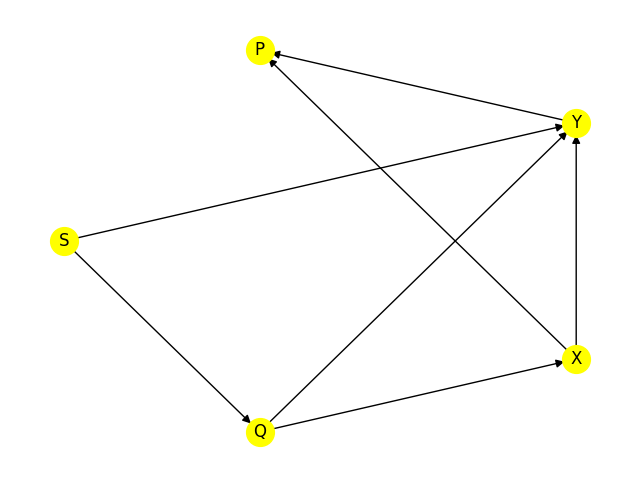

In [11]:
model.view_model()

## 02. estimand 구하기

- 여기서는 backdoor 방법으로 causal effect를 구할 수 있다고 나옵니다.
- graph를 통해서 유추할 수 있었듯이 `X`, `Y`기준 fork인 `Q`를 conditioning하면 backdoor path를 block할 수 있습니다.

In [12]:
estimand = model.identify_effect()

print(estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d          
────(E[Y|Q])
d[X]        
Estimand assumption 1, Unconfoundedness: If U→{X} and U→Y then P(Y|X,Q,U) = P(Y|X,Q)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



## 03. estimate 하기

In [13]:
from sklearn.linear_model import LinearRegression, LogisticRegression, LassoCV
from sklearn.ensemble import GradientBoostingRegressor

- 다양한 방법을 이용하여 estimate할 수 있습니다.

In [ ]:
estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.econml.dml.DML',
    method_params={
        'init_params': {
            'model_y': GradientBoostingRegressor(),
            'model_t': GradientBoostingRegressor(),
            'model_final': LassoCV(fit_intercept=False)
        },
        'fit_params':{}
    }
)

In [26]:
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d          
────(E[Y|Q])
d[X]        
Estimand assumption 1, Unconfoundedness: If U→{X} and U→Y then P(Y|X,Q,U) = P(Y|X,Q)

## Realized estimand
b: Y~X+Q | 
Target units: ate

## Estimate
Mean value: 0.6842788018470468
Effect estimates: [[0.6842788]]



In [16]:
print(f'DML을 이용하여 구한 causal effect는 {estimate.value}입니다.')

DML을 이용하여 구한 causal effect는 0.6842788018470468입니다.


In [18]:
estimate_lr = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.linear_regression'
)

In [20]:
print(f'lr을 이용하여 구한 causal effect는 {estimate_lr.value}입니다.')

lr을 이용하여 구한 causal effect는 0.6714716194006616입니다.


## 04. refute
- 우리가 구한 causal effect가 valid한지 검증test를 합니다.

In [ ]:
random_cause = model.refute_estimate(
    estimand=estimand,
    estimate=estimate,
    method_name='random_common_cause'
)

In [25]:
print(random_cause)

Refute: Add a random common cause
Estimated effect:0.6842788018470468
New effect:0.6561951987191602
p value:0.08000000000000007



In [ ]:
placebo_refuter = model.refute_estimate(
    estimand=estimand,
    estimate=estimate,
    method_name='placebo_treatment_refuter'
)

In [30]:
print(placebo_refuter)

Refute: Use a Placebo Treatment
Estimated effect:0.6842788018470468
New effect:0.0
p value:2.0

